# Определение возраста покупателей

## Исследовательский анализ данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#Загрузка данных
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
print('Размер датасета:')
labels.shape

Размер датасета:


(7591, 2)

In [5]:
print('Первые 5 строк:')
labels.head()

Первые 5 строк:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
print('Количество дубликатов:', labels.duplicated().sum())

Количество дубликатов: 0


In [6]:
print('Количество пропусков:', labels.isna().sum())

Количество пропусков: file_name    0
real_age     0
dtype: int64


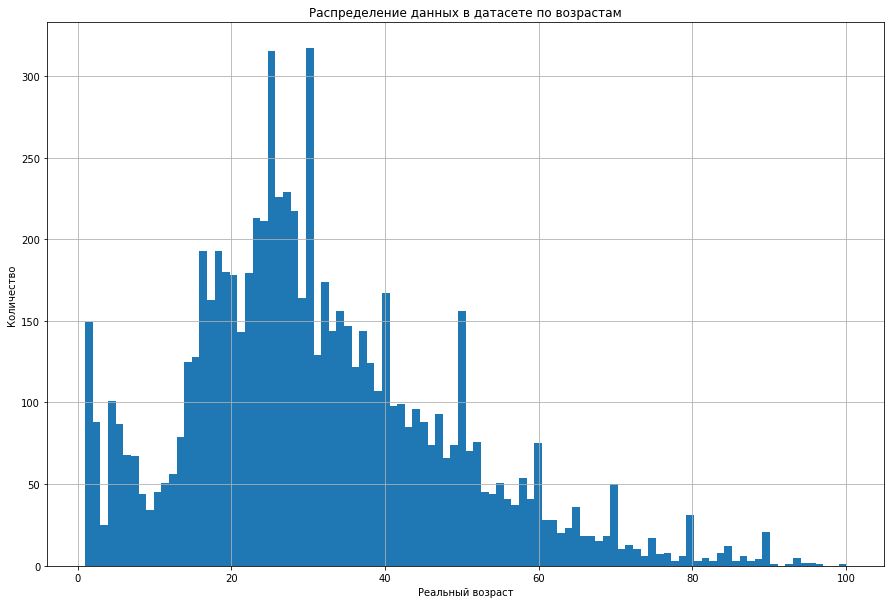

In [7]:
plt.figure(figsize=(15,10))
plt.title('Распределение данных в датасете по возрастам')
plt.xlabel('Реальный возраст')
plt.ylabel('Количество')
labels.real_age.hist(bins=100);

In [11]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [8]:
features, target = next(datagen_flow)

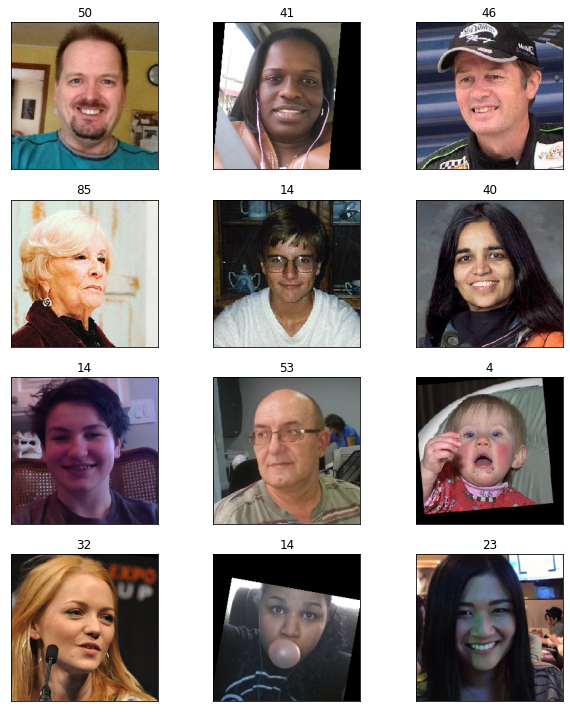

In [10]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<b>Вывод</b>  
В данных 7591 пар объектов. Минамальный возраст 1 год, максимальный возраст 100 лет. Средний возраст - 31, медианный - 29. Большинство фотографий приходятся на возраст от 16 до 50 лет. Данных меньше для людей старше 50 лет, соотвественно вероятность ошибки модели по определению этого возраста будет выше. На графике наблюдаются моды в юбилейные годы, больше всего данных приходится на 25 и 30 лет. На выведеных фотографиях видно, что лица людей расположены с разных сторон, с разным масштабом и некоторые фотографии повернуты.  
Веротянее всего 7591 объекта не хватит для обучения модели, так что буду использовать аугментацию для отражения по горизонтали, чтобы увеличить количество данных.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np


 
def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255.,
                                       validation_split=0.25,
                                       horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow
 
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.00001) 
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae']) 
    return model
 
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/15
2023-07-15 16:42:02.614809: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-15 16:42:02.955456: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 48s - loss: 671.8468 - mae: 20.8675 - val_loss: 1054.2880 - val_mae: 27.8335
Epoch 2/15
178/178 - 40s - loss: 117.7756 - mae: 8.2342 - val_loss: 978.3471 - val_mae: 26.5325
Epoch 3/15
178/178 - 40s - loss: 64.7447 - mae: 6.2306 - val_loss: 565.8606 - val_mae: 18.5278
Epoch 4/15
178/178 - 39s - loss: 43.9778 - mae: 5.1531 - val_loss: 209.6007 - val_mae: 10.8086
Epoch 5/15
178/178 - 40s - loss: 33.1404 - mae: 4.4464 - val_loss: 129.0748 - val_mae: 8.7820
Epoch 6/15
178/178 - 42s - loss: 24.6284 - mae: 3.8588 - val_loss: 97.2431 - val_mae: 7.6405
Epoch 7/15
178/178 - 41s - loss: 20.8245 - mae: 3.5319 - val_loss: 87.1038 - val_mae: 7.0792
Epoch 8/15
178/178 - 39s - loss: 17.0284 - mae: 3.2112 - val_loss: 85.5965 - val_mae: 6.9996
Epoch 9/15
178/178 - 40s - loss: 15.1035 - mae: 2.9844 - val_loss: 84.4299 - val_mae: 6.8743
Epoch 10/15
178/178 - 40s - loss: 13.8173 - mae: 2.8335 - val_loss: 86.2294 - val_mae: 7.0211
Epoch 11/15
178/178 - 39s - loss: 12.2385 - mae: 2.6724 - val_loss: 84.4325 - val_mae: 6.9173
Epoch 12/15
178/178 - 39s - loss: 10.9882 - mae: 2.5735 - val_loss: 83.6751 - val_mae: 6.9312
Epoch 13/15
178/178 - 39s - loss: 10.6422 - mae: 2.5005 - val_loss: 83.3119 - val_mae: 6.8798
Epoch 14/15
178/178 - 40s - loss: 9.2070 - mae: 2.3569 - val_loss: 83.6955 - val_mae: 6.9889
Epoch 15/15
178/178 - 39s - loss: 8.1889 - mae: 2.2123 - val_loss: 81.9526 - val_mae: 6.8197
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 81.9526 - mae: 6.8197
Test MAE: 6.8197
```

## Анализ обученной модели

<b>Вывод</b>  
Данные были разделены на обучающие и тестовые. Вобучающей выборке использовал аугментацию для отражения по горизонтали. Сеть построена на архитектуре ResNet50 с lerning_rate=0.0001, функцией потерь - MSE, метрикой качества MAE и функцией активации relu. Модель обучалась на 15 эпохах в итоге минимальная MAE - 6.8743 на 9 эпохе, а на 15 - 6.8197, что ниже заданной в задании границы - 8. Сеть справилась с поставленной задачей.